In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
DATA_DIR = r"D:/MLInMedicine/smallll"

available_series = {
    f.replace(".mhd", "")
    for f in os.listdir(DATA_DIR)
    if f.endswith(".mhd")
}

print("Available CT volumes:", len(available_series))

annotations = pd.read_csv(
    os.path.join(DATA_DIR, "annotations.csv")
)

annotations = annotations[
    annotations["seriesuid"].isin(available_series)
].reset_index(drop=True)

print("Filtered annotations:", len(annotations))

missing = set(annotations["seriesuid"]) - available_series
print("Still missing:", len(missing))



Available CT volumes: 12
Filtered annotations: 14
Still missing: 0


In [3]:
def load_mhd(path):
    image = sitk.ReadImage(path)
    array = sitk.GetArrayFromImage(image) 
    origin = np.array(image.GetOrigin())
    spacing = np.array(image.GetSpacing())
    return array, origin, spacing


In [4]:
def world_to_voxel(world_coord, origin, spacing):
    return np.round((world_coord - origin) / spacing).astype(int)

In [5]:
def extract_patch(volume, center, size=32):
    z, y, x = center
    half = size // 2

    z = np.clip(z, half, volume.shape[0] - half)
    y = np.clip(y, half, volume.shape[1] - half)
    x = np.clip(x, half, volume.shape[2] - half)

    z0, z1 = z - half, z + half
    y0, y1 = y - half, y + half
    x0, x1 = x - half, x + half

    patch = volume[z0:z1, y0:y1, x0:x1]

    assert patch.shape == (size, size, size), f"Bad patch shape: {patch.shape}"

    return patch


In [6]:
class LungNoduleDataset(Dataset):
    def __init__(self, annotations, data_dir, patch_size=32):
        self.annotations = annotations
        self.data_dir = data_dir
        self.patch_size = patch_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        seriesuid = row["seriesuid"]
        
        mhd_path = os.path.join(self.data_dir, seriesuid + ".mhd")
        volume, origin, spacing = load_mhd(mhd_path)

        world_coord = np.array([row["coordZ"], row["coordY"], row["coordX"]])
        voxel_coord = world_to_voxel(world_coord, origin, spacing)

        patch = extract_patch(volume, voxel_coord, size=32)
        patch = np.clip(patch, -1000, 400)
        patch = (patch + 1000) / 1400

        patch = torch.from_numpy(patch).unsqueeze(0).float()
        label = torch.tensor(1.0)

        return patch, label

In [7]:
dataset = LungNoduleDataset(annotations, DATA_DIR)
loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0
)

In [8]:
class NoduleNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1),

            nn.Flatten(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [12]:
model = NoduleNet3D().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history = []

for epoch in range(5):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(loader)
    loss_history.append(epoch_loss)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.6591
Epoch 2, Loss: 0.6088
Epoch 3, Loss: 0.5453
Epoch 4, Loss: 0.4540
Epoch 5, Loss: 0.3317


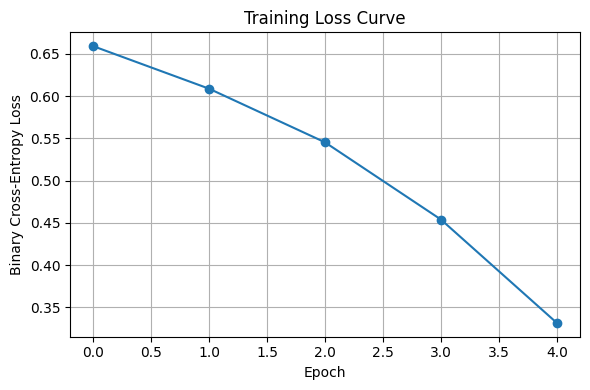

In [13]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

Predicted nodule probability: 0.7995


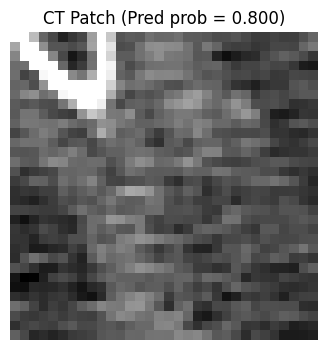

In [16]:
model.eval()

with torch.no_grad():
    patch, label = dataset[0]
    volume = patch.unsqueeze(0).to(device)

    prob = model(volume).item()

print(f"Predicted nodule probability: {prob:.4f}")

ct = patch[0].cpu().numpy()
slice_id = ct.shape[0] // 2

plt.figure(figsize=(4,4))
plt.imshow(ct[slice_id], cmap="gray")
plt.title(f"CT Patch (Pred prob = {prob:.3f})")
plt.axis("off")
plt.show()

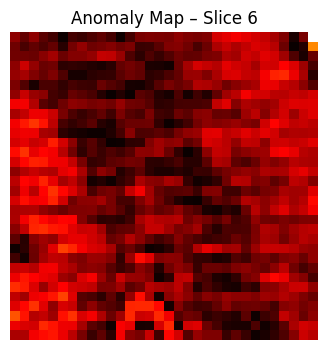

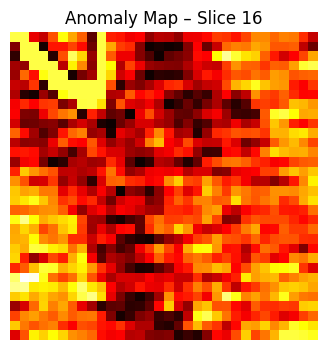

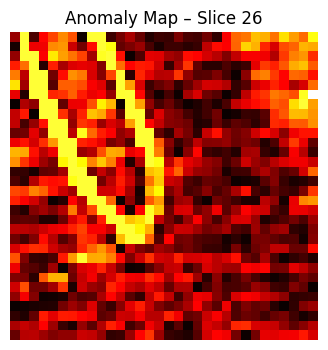

In [17]:
for s in [slice_id-10, slice_id, slice_id+10]:
    plt.figure(figsize=(4,4))
    plt.imshow(error_map[s], cmap="hot")
    plt.title(f"Anomaly Map – Slice {s}")
    plt.axis("off")
    plt.show()